In [46]:

# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score


from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:

# Load dataset
df = pd.read_csv("data\emi_prediction_dataset.csv")
df.head(20)


C:\Users\harih\AppData\Local\Temp\ipykernel_13976\3213873743.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data\emi_prediction_dataset.csv")


,age,gender,marital_status,education,monthly_salary,employment_type,years_of_employment,company_type,house_type,monthly_rent,family_size,dependents,school_fees,college_fees,travel_expenses,groceries_utilities,other_monthly_expenses,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,emi_scenario,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi
0,38.0,Female,Married,Professional,82600.0,Private,0.9,Mid-size,Rented,20000.0,3,2,0.0,0.0,7200.0,19500.0,13200.0,Yes,23700.0,660.0,303200.0,70200.0,Personal Loan EMI,850000.0,15,Not_Eligible,500.00
1,38.0,Female,Married,Graduate,21500.0,Private,7.0,MNC,Family,0.0,2,1,5100.0,0.0,1400.0,5400.0,3500.0,Yes,4100.0,714.0,92500.0,26900.0,E-commerce Shopping EMI,128000.0,19,Not_Eligible,700.00
2,38.0,Male,Married,Professional,86100.0,Private,5.8,Startup,Own,0.0,4,3,0.0,0.0,10200.0,19400.0,6000.0,No,0.0,650.0,672100.0,324200.0,Education EMI,306000.0,16,Eligible,27775.00
3,58.0,Female,Married,High School,66800.0,Private,2.2,Mid-size,Own,0.0,5,4,11400.0,0.0,6200.0,11900.0,7900.0,No,0.0,685.0,440900.0,178100.0,Vehicle EMI,304000.0,83,Eligible,16170.00
4,48.0,Female,Married,Professional,57300.0,Private,3.4,Mid-size,Family,0.0,4,3,9400.0,21300.0,3600.0,16200.0,8100.0,No,0.0,770.0,97300.0,28200.0,Home Appliances EMI,252000.0,7,Not_Eligible,500.00
5,38.0,Male,Married,High School,38800.0,Government,5.0,Large Indian,Rented,13500.0,4,3,0.0,24100.0,3400.0,8200.0,6700.0,No,0.0,792.0,260800.0,55600.0,Vehicle EMI,1257000.0,53,Not_Eligible,500.00
6,58.0,Male,Single,High School,27100.0,Private,36.0,Large Indian,Own,0.0,3,2,10200.0,0.0,1600.0,7300.0,4100.0,No,0.0,741.0,68000.0,36200.0,Home Appliances EMI,280000.0,11,Not_Eligible,1950.00
7,58.0,Female,Married,Post Graduate,392044.0,Private,12.9,MNC,Family,0.0,4,3,0.0,0.0,5600.0,12300.0,3000.0,Yes,9900.0,623.0,184600.0,61700.0,E-commerce Shopping EMI,153000.0,12,Not_Eligible,8260.00
8,58.0,Female,Married,Professional,47700.0,Private,36.0,Large Indian,Family,0.0,3,2,15000.0,0.0,6100.0,7300.0,8300.0,No,0.0,712.0,235600.0,81800.0,E-commerce Shopping EMI,106000.0,14,Not_Eligible,5500.00
9,32.0,female,Single,Post Graduate,129200.0,Private,1.9,MNC,Family,0.0,2,1,8100.0,11300.0,11800.0,24100.0,16500.0,Yes,33100.0,681.0,963200.0,519100.0,E-commerce Shopping EMI,81000.0,3,Not_Eligible,9355.50



##  Step 1: Clean Target


In [3]:

# Inspect raw target
df["emi_eligibility"].value_counts(dropna=False)
df["emi_eligibility"] = (
    df["emi_eligibility"]
    .astype(str)
    .str.strip()
    .str.lower()
)
df["emi_eligibility"].value_counts(dropna=False)


emi_eligibility
not_eligible    312868
eligible         74444
high_risk        17488
Name: count, dtype: int64

In [4]:

# Normalize target values


target_map = {
    "eligible": 1,
    "not_eligible": 0,
    "high_risk":0

}

df["emi_eligibility"] = df["emi_eligibility"].map(target_map)

# Drop invalid targets
df = df.dropna(subset=["emi_eligibility"])
df["emi_eligibility"] = df["emi_eligibility"].astype(int)

df["emi_eligibility"].value_counts()


emi_eligibility
0    330356
1     74444
Name: count, dtype: int64

In [45]:
df["max_monthly_emi"].describe()

count    388230.000000
mean       6440.243844
std        6648.055024
min         500.000000
25%         500.000000
50%        4213.440000
75%        9792.000000
max       23730.000000
Name: max_monthly_emi, dtype: float64


## Step 2: Data Cleaning


In [5]:
df["existing_loans"].value_counts(dropna=False)

existing_loans
No     243227
Yes    161573
Name: count, dtype: int64

In [6]:
df["existing_loans"] = df["existing_loans"].map({'Yes': 1, 'No': 0}).astype("Int64")
df["existing_loans"].value_counts(dropna=False)


existing_loans
0    243227
1    161573
Name: count, dtype: Int64

In [7]:
import numpy as np
import pandas as pd

def clean_numeric(series):
    s = series.astype(str).str.strip()

    # Remove all characters except digits and dots
    s = s.str.replace(r"[^0-9.]", "", regex=True)

    # Fix cases like '58.0.0' → keep only first dot
    s = s.str.replace(r"\.(?=.*\.)", "", regex=True)

    # Empty strings → NaN
    s = s.replace("", np.nan)

    return s.astype(float)


In [8]:
numeric_cols = [
    "age",
    "monthly_salary",
    "years_of_employment",
    "dependents",
    "credit_score",
    "requested_amount",
    "requested_tenure",
    "expenses",
    "disposable_funds"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = clean_numeric(df[col])


In [9]:
df.dropna(
    subset=["monthly_rent", "credit_score", "emergency_fund","education","bank_balance"],
    inplace=True
)
df.drop(columns=['gender','marital_status','family_size'], axis=1, inplace=True)


In [10]:
df.dtypes

age                       float64
education                  object
monthly_salary            float64
employment_type            object
years_of_employment       float64
company_type               object
house_type                 object
monthly_rent              float64
dependents                float64
school_fees               float64
college_fees              float64
travel_expenses           float64
groceries_utilities       float64
other_monthly_expenses    float64
existing_loans              Int64
current_emi_amount        float64
credit_score              float64
bank_balance               object
emergency_fund            float64
emi_scenario               object
requested_amount          float64
requested_tenure          float64
emi_eligibility             int64
max_monthly_emi           float64
dtype: object

In [11]:
categorical_cols = df.select_dtypes(
    include=['object', 'category']
).columns.tolist()
pseudo_categorical = [
    col for col in df.select_dtypes(include=['int64', 'float64']).columns
    if df[col].nunique() < 15
]

pseudo_categorical
all_categorical_cols = categorical_cols + pseudo_categorical
df[all_categorical_cols].head()

,education,employment_type,company_type,house_type,bank_balance,emi_scenario,dependents,existing_loans,emi_eligibility
0,Professional,Private,Mid-size,Rented,303200.0,Personal Loan EMI,2.0,1,0
1,Graduate,Private,MNC,Family,92500.0,E-commerce Shopping EMI,1.0,1,0
2,Professional,Private,Startup,Own,672100.0,Education EMI,3.0,0,1
3,High School,Private,Mid-size,Own,440900.0,Vehicle EMI,4.0,0,1
4,Professional,Private,Mid-size,Family,97300.0,Home Appliances EMI,3.0,0,0


In [12]:
df['education'] = df['education'].str.strip().str.title()
education_map = {
    'High School': 0,
    'Graduate': 1,
    'Professional': 3,
    'Post Graduate': 2,
}

df['education_enc'] = df['education'].map(education_map)
df['education_enc'].value_counts(dropna=False)
df.drop(columns=['education'],inplace=True)

In [13]:
df['employment_type'] = df['employment_type'].str.strip().str.title()
employment_map = {
    'Self-Employed': 1,
    'Private': 2,
    'Government': 3
}

df['employment_type_enc'] = df['employment_type'].map(employment_map)

df['employment_type_enc'].value_counts(dropna=False)
df.drop(columns=['employment_type'],inplace=True)

In [14]:
company_map = {
    'Startup': 0,
    'Small': 1,
    'Mid-size': 2,
    'Large Indian': 3,
    'MNC': 4
}

df['company_type_enc'] = df['company_type'].map(company_map)
df['company_type_enc'].value_counts()
df.drop(columns=['company_type'],inplace=True)

In [15]:
df['house_type'] = df['house_type'].str.strip().str.title()
house_map = {
    'Rented': 0,
    'Family': 1,
    'Own': 2
}

df['house_type_enc'] = df['house_type'].map(house_map)

df['house_type_enc'].value_counts()
df.drop(columns=['house_type'],inplace=True)

In [16]:
df['emi_scenario'] = df['emi_scenario'].str.replace(' EMI', '', regex=False)
df['emi_scenario'].value_counts()
df['emi_scenario'] = (
    df['emi_scenario']
    .str.strip()
    .str.title()
)
# One hot encoding for non ordinal data
df = pd.get_dummies(
    df,
    columns=['emi_scenario'],
    drop_first=True
)


In [17]:
df.head()

,age,monthly_salary,years_of_employment,monthly_rent,dependents,school_fees,college_fees,travel_expenses,groceries_utilities,other_monthly_expenses,existing_loans,current_emi_amount,credit_score,bank_balance,emergency_fund,requested_amount,requested_tenure,emi_eligibility,max_monthly_emi,education_enc,employment_type_enc,company_type_enc,house_type_enc,emi_scenario_Education,emi_scenario_Home Appliances,emi_scenario_Personal Loan,emi_scenario_Vehicle
0,38.0,82600.0,0.9,20000.0,2.0,0.0,0.0,7200.0,19500.0,13200.0,1,23700.0,660.0,303200.0,70200.0,850000.0,15.0,0,500.0,3,2,2,0,False,False,True,False
1,38.0,21500.0,7.0,0.0,1.0,5100.0,0.0,1400.0,5400.0,3500.0,1,4100.0,714.0,92500.0,26900.0,128000.0,19.0,0,700.0,1,2,4,1,False,False,False,False
2,38.0,86100.0,5.8,0.0,3.0,0.0,0.0,10200.0,19400.0,6000.0,0,0.0,650.0,672100.0,324200.0,306000.0,16.0,1,27775.0,3,2,0,2,True,False,False,False
3,58.0,66800.0,2.2,0.0,4.0,11400.0,0.0,6200.0,11900.0,7900.0,0,0.0,685.0,440900.0,178100.0,304000.0,83.0,1,16170.0,0,2,2,2,False,False,False,True
4,48.0,57300.0,3.4,0.0,3.0,9400.0,21300.0,3600.0,16200.0,8100.0,0,0.0,770.0,97300.0,28200.0,252000.0,7.0,0,500.0,3,2,2,1,False,True,False,False


In [18]:
df['monthly_salary'].dtypes
df['monthly_salary'].head()
df['monthly_salary'] = (
    df['monthly_salary']
    .astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
)


In [19]:
df['monthly_salary'] = pd.to_numeric(
    df['monthly_salary'],
    errors='coerce'
)


In [20]:
df['bank_balance'] = (
    df['bank_balance']
    .astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
)
df['bank_balance'] = pd.to_numeric(
    df['bank_balance'],
    errors='coerce'
)


In [21]:
df.drop('bank_balance', axis=1, inplace=True)

In [22]:
expense_cols = [
    'monthly_rent','school_fees','college_fees', 'travel_expenses', 'groceries_utilities','other_monthly_expenses','current_emi_amount'
]
df['expenses'] = df[expense_cols].sum(axis=1)
df.drop(columns=expense_cols, inplace=True)

In [23]:



#ytrain.value_counts(normalize=True)


## Outlier Detection and correction

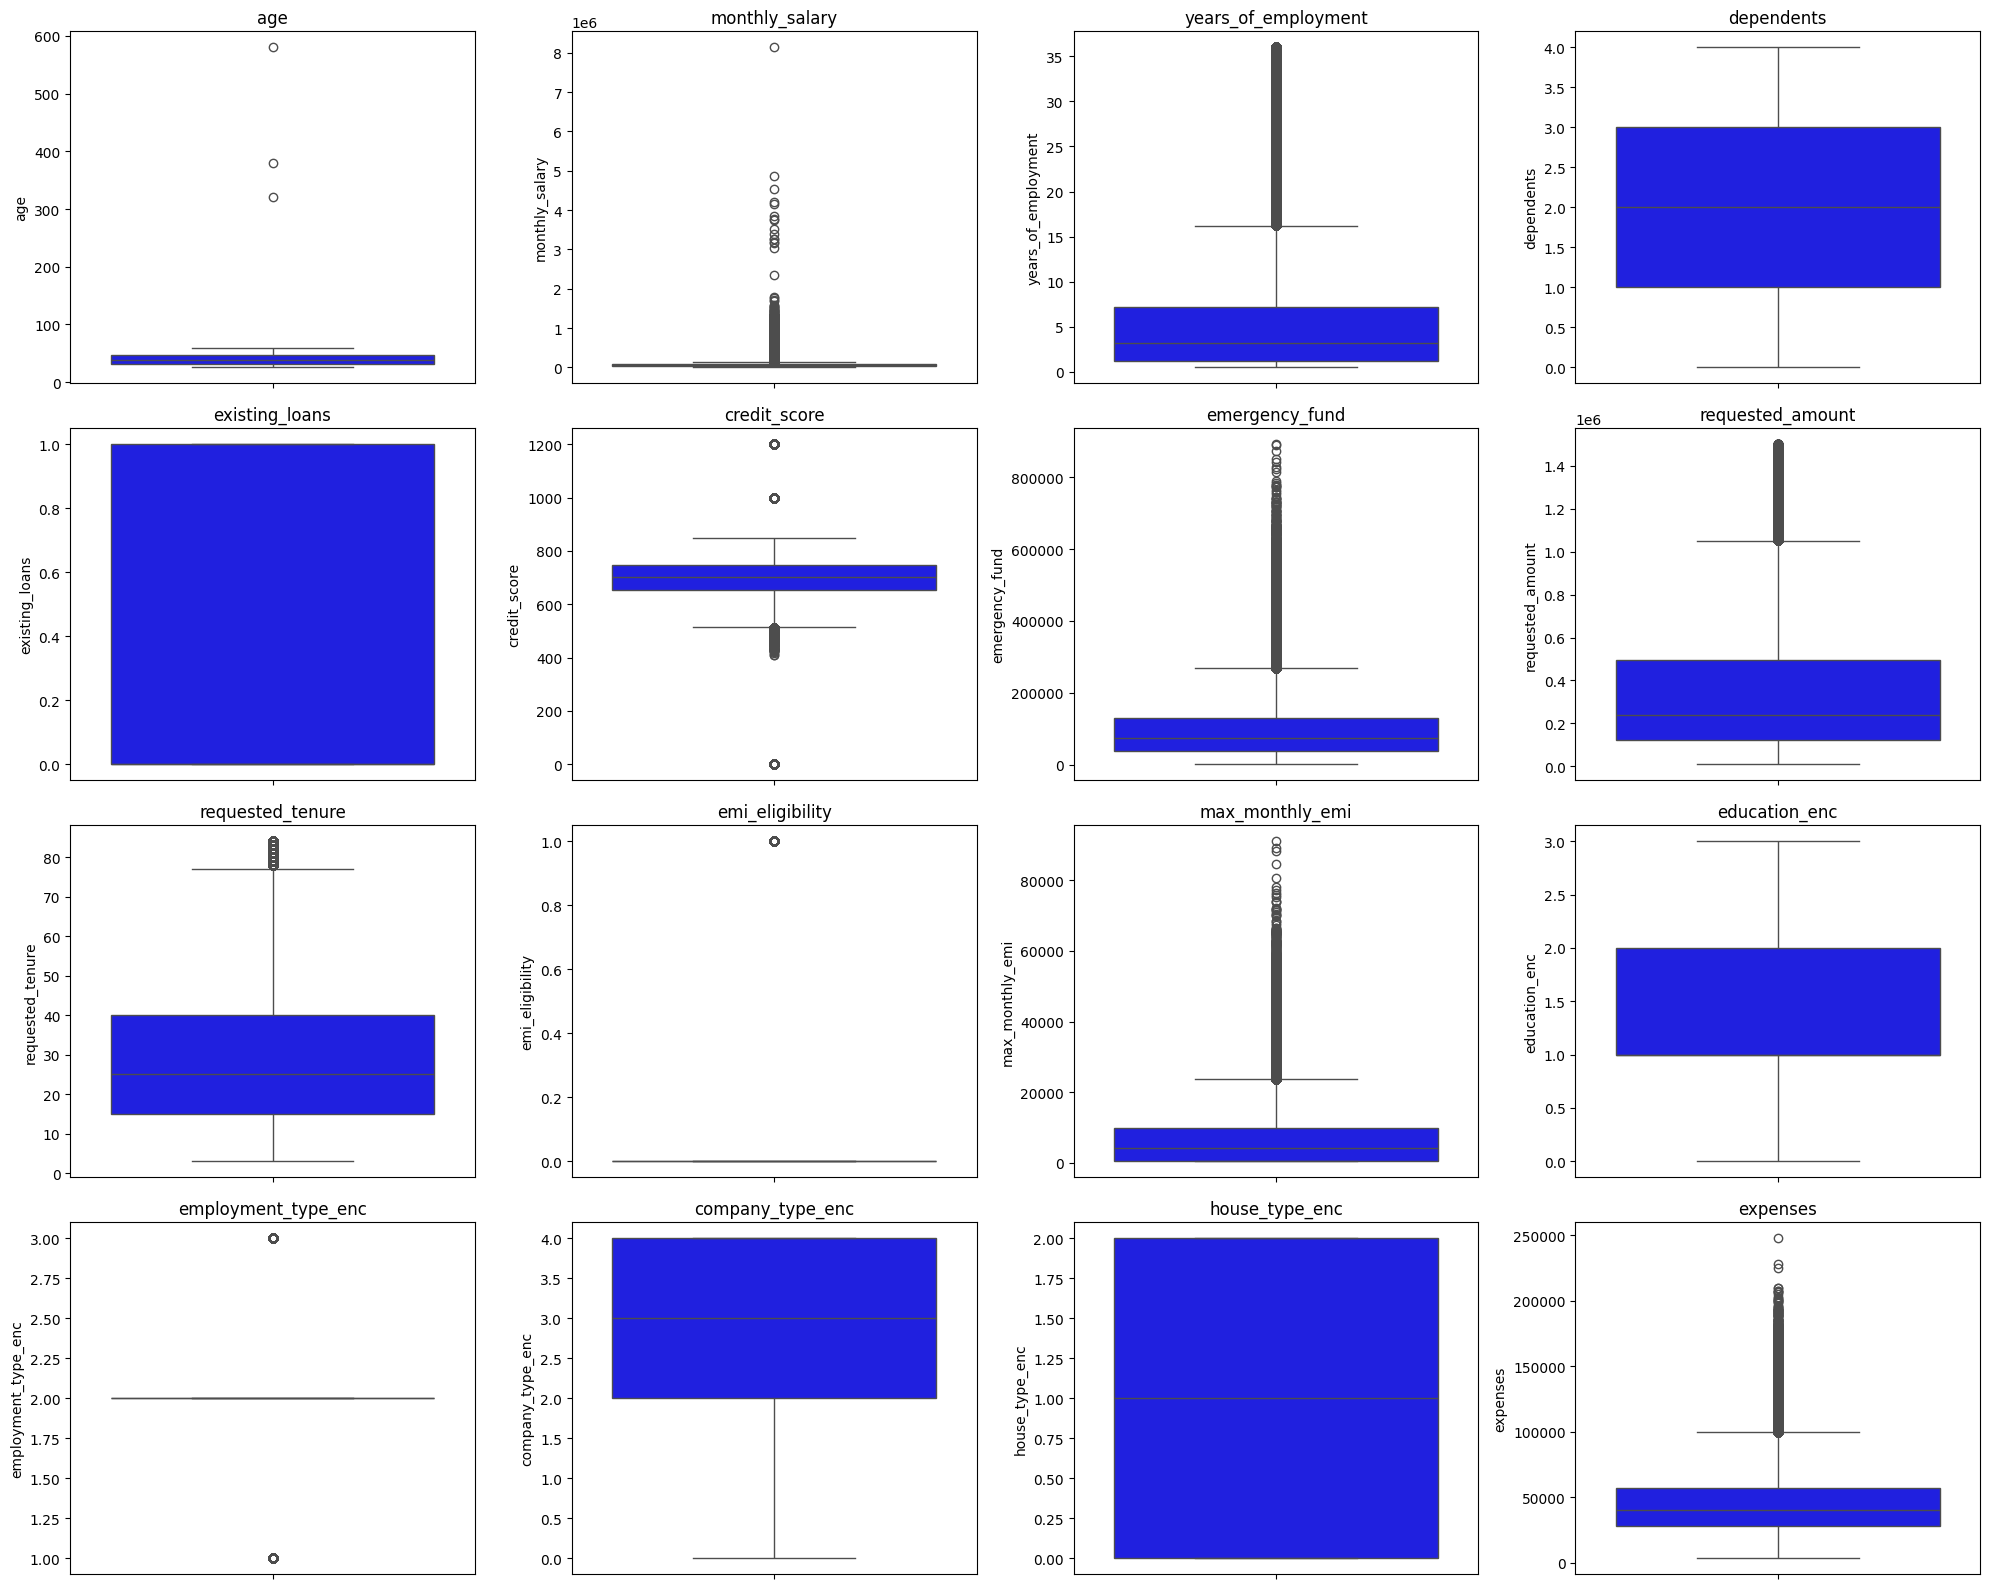

In [24]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

float_features = df.select_dtypes(exclude=['bool','object']).columns

n_cols = 4
n_rows = math.ceil(len(float_features) / n_cols)

plt.figure(figsize=(5*n_cols, 4*n_rows))

for i, feature in enumerate(float_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=df[feature], color='blue')
    plt.title(feature)

plt.tight_layout()
plt.show()

In [25]:
df = df[
    (df["age"].between(18, 100)) &
    (df["credit_score"].between(300, 900)) &
    (df["years_of_employment"] >= 0) &
    (df["years_of_employment"] <= (df["age"] - 18)) &
    (df["dependents"].between(0, 10))
]


In [26]:
cap_cols = [
    "monthly_salary",
    "emergency_fund",
    "requested_amount",
    "max_monthly_emi",
    "expenses"
]


In [27]:
def cap_outliers(df, col, factor=1.5):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    df[col] = df[col].clip(lower, upper)
    return df


In [28]:
for col in cap_cols:
    df = cap_outliers(df, col)


In [73]:
X = df.drop(columns=["emi_eligibility", "max_monthly_emi"])
y = df["emi_eligibility"]
yreg=df["max_monthly_emi"]
print(X.isnull().sum())
X = X.astype(float)

xtrain, xtest, ytrain, ytest = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

xtrain2, xtest2, ytrain2, ytest2 = train_test_split(
    X, yreg,
    test_size=0.2,
    random_state=44,
    stratify=y
)
xtrain.columns

age                             0
monthly_salary                  0
years_of_employment             0
dependents                      0
existing_loans                  0
credit_score                    0
emergency_fund                  0
requested_amount                0
requested_tenure                0
education_enc                   0
employment_type_enc             0
company_type_enc                0
house_type_enc                  0
emi_scenario_Education          0
emi_scenario_Home Appliances    0
emi_scenario_Personal Loan      0
emi_scenario_Vehicle            0
expenses                        0
dtype: int64


Index(['age', 'monthly_salary', 'years_of_employment', 'dependents',
       'existing_loans', 'credit_score', 'emergency_fund', 'requested_amount',
       'requested_tenure', 'education_enc', 'employment_type_enc',
       'company_type_enc', 'house_type_enc', 'emi_scenario_Education',
       'emi_scenario_Home Appliances', 'emi_scenario_Personal Loan',
       'emi_scenario_Vehicle', 'expenses'],
      dtype='object')

## Balance the samples

In [30]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(xtrain, ytrain)


# MLFLOW Tracking

In [59]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost


In [62]:
#mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("EMI_Modeling")


2026/01/08 12:37:23 INFO mlflow.tracking.fluent: Experiment with name 'EMI_Modeling' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1767856043195, experiment_id='1', last_update_time=1767856043195, lifecycle_stage='active', name='EMI_Modeling', tags={}>

In [64]:

def log_classification_metrics(y_true, y_pred, y_proba=None):
    mlflow.log_metric("accuracy", accuracy_score(y_true, y_pred))
    mlflow.log_metric("precision", precision_score(y_true, y_pred, average="weighted"))
    mlflow.log_metric("recall", recall_score(y_true, y_pred, average="weighted"))
    mlflow.log_metric("f1_score", f1_score(y_true, y_pred, average="weighted"))

    if y_proba is not None:
        mlflow.log_metric("roc_auc", roc_auc_score(y_true, y_proba))



def log_regression_metrics(y_true, y_pred):
    mlflow.log_metric("MAE", mean_absolute_error(y_true, y_pred))
    mlflow.log_metric("RMSE", mean_squared_error(y_true, y_pred) ** 0.5)
    mlflow.log_metric("R2", r2_score(y_true, y_pred))



## Build Classification Models Pipeline

In [65]:
with mlflow.start_run(run_name="Logistic_Regression_Classifier"):
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("max_iter", 1000)

    pipe_lr = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="lbfgs"
        ))
    ])
    pipe_lr.fit(X_res, y_res)
    lr_pred = pipe_lr.predict(xtest)
    lr_proba = pipe_lr.predict_proba(xtest)[:, 1]
    log_classification_metrics(ytest, lr_pred, lr_proba)
    mlflow.sklearn.log_model(pipe_lr, "model")

    '''lr_metrics = {
        "Model": "Logistic Regression",
        "Accuracy": accuracy_score(ytest, lr_pred),
        "Precision": precision_score(ytest, lr_pred, average="weighted"),
        "Recall": recall_score(ytest, lr_pred, average="weighted"),
        "F1-Score": f1_score(ytest, lr_pred, average="weighted")
    }'''




2026/01/08 12:45:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Logistic_Regression_Classifier at: http://127.0.0.1:5000/#/experiments/1/runs/ecfe2caaca484370a55c5ef2d3c42a49
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [66]:
with mlflow.start_run(run_name="RandomForest_Classifier"):

    mlflow.log_param("n_estimators", 150)
    mlflow.log_param("max_depth", 12)


    pipe_rf = Pipeline([
        ("model", RandomForestClassifier(
            n_estimators=150,
            max_depth=12,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features="sqrt",
            n_jobs=-1,
            random_state=42,
            class_weight="balanced"
        ))
    ])

    pipe_rf.fit(X_res, y_res)

    rf_pred = pipe_rf.predict(xtest)
    rf_proba = pipe_rf.predict_proba(xtest)[:, 1]

    log_classification_metrics(ytest, rf_pred, rf_proba)

    mlflow.sklearn.log_model(pipe_rf, "model")
    
    '''rf_metrics = {
        "Model": "Random Forest",
        "Accuracy": accuracy_score(ytest, rf_pred),
        "Precision": precision_score(ytest, rf_pred, average="weighted"),
        "Recall": recall_score(ytest, rf_pred, average="weighted"),
        "F1-Score": f1_score(ytest, rf_pred, average="weighted")
    }
    rf_metrics'''

2026/01/08 12:49:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run RandomForest_Classifier at: http://127.0.0.1:5000/#/experiments/1/runs/33e1471ca8f24da78828d449e0fb0e4c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [68]:
with mlflow.start_run(run_name="XGBoost_Classifier"):

    mlflow.log_param("n_estimators", 300)
    mlflow.log_param("max_depth", 5)
    mlflow.log_param("learning_rate", 0.05)

    pos_weight = (y_res == 0).sum() / (y_res == 1).sum()

    pipe_xgbc = Pipeline([
        ("scaler", StandardScaler()),
        ("model", XGBClassifier(
            n_estimators=300,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=pos_weight,
            eval_metric="logloss",
            random_state=42
        ))
    ])
    pipe_xgbc.fit(X_res, y_res)

    xgbcpred_test = pipe_xgbc.predict(xtest)
    xgbcproba_test = pipe_xgbc.predict_proba(xtest)[:, 1]
    log_classification_metrics(ytest, xgbcpred_test, xgbcproba_test)
    mlflow.sklearn.log_model(pipe_xgbc, artifact_path="model")

    '''print(classification_report(ytest, xgbcpred_test))
    print("ROC-AUC:", roc_auc_score(ytest, xgbcproba_test))'''

2026/01/08 12:57:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run XGBoost_Classifier at: http://127.0.0.1:5000/#/experiments/1/runs/0967594094724da2a7da7648de5472eb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [ ]:
import pandas as pd
gc_features = pd.DataFrame(0, columns=xtrain.columns, index=[0])

gc_features.loc[0, "age"] = 38
gc_features.loc[0, "monthly_salary"] = 85000
gc_features.loc[0, "years_of_employment"] = 6.5
gc_features.loc[0, "credit_score"] = 780
gc_features.loc[0, "requested_amount"] = 300000
gc_features.loc[0, "requested_tenure"] = 36

# expenses is REQUIRED
gc_features.loc[0, "expenses"] = 27000

# EMI scenario (choose exactly ONE)
gc_features.loc[0, "emi_scenario_Personal Loan"] = 1
gc_features.loc[0, "education_enc"] = 3          # Graduate
gc_features.loc[0, "employment_type_enc"] = 2    # Private / Full-time
gc_features.loc[0, "company_type_enc"] = 2       # Mid-size
gc_features.loc[0, "house_type_enc"] = 1         # Own / Family
gc_features.loc[0, "existing_loans"] = 0          # No existing loans


gc_features = gc_features[xtrain.columns]
pipe.predict(gc_features)
#pipe.predict_proba(gc_features)


C:\Users\harih\AppData\Local\Temp\ipykernel_13976\1159056546.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  gc_features.loc[0, "years_of_employment"] = 6.5


## REGRESSION MODELS

In [49]:
def regression_metrics(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred)**0.5,
        "R2": r2_score(y_true, y_pred)
    }


In [ ]:
with mlflow.start_run(run_name="Linear_Regression_EMI"):

    mlflow.log_param("model_type", "LinearRegression")
    pipe_lr = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ])

    pipe_lr.fit(xtrain2, ytrain2)
    lr_pred = pipe_lr.predict(xtest2)

    log_regression_metrics(ytest2, lr_pred)
    mlflow.sklearn.log_model(pipe_lr, "model")

    '''lr_results = regression_metrics(ytest2, lr_pred, "Linear Regression")
    lr_results'''

2026/01/08 13:02:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Linear_Regression_EMI at: http://127.0.0.1:5000/#/experiments/1/runs/1487e965ed9b4358bd8c56bf42cbce83
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [55]:
ytrain2.describe()


count    310584.000000
mean       6432.700634
std        6644.453358
min         500.000000
25%         500.000000
50%        4200.000000
75%        9780.000000
max       23730.000000
Name: max_monthly_emi, dtype: float64

In [71]:
with mlflow.start_run(run_name="RandomForest_Regressor_EMI"):

    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("max_depth", 15)


    pipe_rf = Pipeline([
        ("model", RandomForestRegressor(
            n_estimators=200,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features="sqrt",
            n_jobs=-1,
            random_state=42
        ))
    ])

    pipe_rf.fit(xtrain2, ytrain2)
    rf_pred = pipe_rf.predict(xtest2)

    log_regression_metrics(ytest2, rf_pred)

    mlflow.sklearn.log_model(pipe_rf, "model")

    '''rf_results = regression_metrics(ytest2, rf_pred, "Random Forest Regressor")
    rf_results'''

2026/01/08 13:05:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run RandomForest_Regressor_EMI at: http://127.0.0.1:5000/#/experiments/1/runs/8983afb808d945bc8e3eeb1b7fbdd71f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [72]:
with mlflow.start_run(run_name="XGBoost_Regressor_EMI"):

    mlflow.log_param("n_estimators", 400)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("learning_rate", 0.05)


    pipe_xgb = Pipeline([
        ("model", XGBRegressor(
            n_estimators=400,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        ))
    ])

    pipe_xgb.fit(xtrain2, ytrain2)
    xgb_pred = pipe_xgb.predict(xtest2)

    log_regression_metrics(ytest2, xgb_pred)

    #mlflow.xgboost.log_model(pipe_xgb.named_steps["model"], "model")
    mlflow.sklearn.log_model(pipe_xgb, artifact_path="model")

    '''xgb_results = regression_metrics(ytest2, xgb_pred, "XGBoost Regressor")
    xgb_results'''

2026/01/08 13:09:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run XGBoost_Regressor_EMI at: http://127.0.0.1:5000/#/experiments/1/runs/d0e2857fef5a4980a19877aff5005f2e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [58]:
pipe_xgb.predict(gc_features)

array([22065.463], dtype=float32)